Enfoque del dataset de noticias falsas basado en CNN

In [ ]:
### IMPORTS ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import tensorflow as tf
tf.random.set_seed(55) # para asegurar experimentos son reproducibles
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, Conv1D, MaxPooling1D

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

from sklearn.metrics import accuracy_score, classification_report 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

!pip install textaugment
from textaugment import EDA

import gensim.downloader as api

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Cargar Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

PATH = "/content/drive/My Drive/PLN/Práctica Final PLN/Data/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
### CONJUNTOS DE ENTRENAMIENTO, VALIDACIÓN Y TEST ###
df = pd.read_csv(PATH + "train.csv",  sep=',', on_bad_lines='skip', encoding='utf-8', encoding_errors='ignore')
df = df[['tweet', 'mean_prejudice']]
df = df.rename(columns={"tweet": "Text", "mean_prejudice": "Label"})
df.fillna(" ", inplace=True)

X_train = df['Text']
y_train = df['Label']

X_train, X_aux, y_train, y_aux = train_test_split(X_train, y_train, test_size=0.3, random_state=55)
X_val, X_test, y_val, y_test = train_test_split(X_aux, y_aux, test_size=0.66, random_state=55)

X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

print('Tamaño conjunto de Entrenamiento:', len(X_train))
print('Tamaño conjunto de Validación:', len(X_val))
print('Tamaño conjunto de Evaluación:', len(X_test))

Tamaño conjunto de Entrenamiento: 1869
Tamaño conjunto de Validación: 272
Tamaño conjunto de Evaluación: 530


# Data Augmentation

t = EDA()

i = 0
for i in range(1869):
    new_text = t.synonym_replacement(X_train[i])
    X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
    y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)
    
    new_text = t.random_swap(X_train[i])
    X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
    y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)
    
    new_text = t.random_deletion(X_train[i])
    X_train = X_train.append(pd.Series([new_text]), ignore_index=True)
    y_train = y_train.append(pd.Series([y_train[i]]), ignore_index=True)
    
    i = i + 1
    
print('Tamaño conjunto de Entrenamiento:', len(X_train))
print('Tamaño conjunto de Evaluación:', len(X_test)) 

# Preprocesamiento y Limpieza

In [ ]:
### LIMPIEZA DE TEXTOS ###
stopwords_es = stopwords.words("spanish")
def clean_text(text):
    # transformar a minúscula
    text=str(text).lower()
    # tokenizar
    tokens=word_tokenize(text)
    # borrar stopwords
    tokens = [word for word in tokens if word not in stopwords_es]
    # usar los stems
    tokens = [PorterStemmer().stem(word) for word in tokens]
    # eliminamos las palabras con 1 carácter
    # ignoramos cualquier palabra que contenga un digito o un símbolo especial 
    min_length = 1
    p = re.compile('^[a-zA-Z]+$');
    filtered_tokens=[]
    for token in tokens:
        if len(token)>= min_length and p.match(token):
            filtered_tokens.append(token)
    
    new_text = ""
    for token in filtered_tokens:
        new_text = new_text + str(token) + " "
    
    return new_text


for text in X_train:
    text = clean_text(text)

# Tokenización

In [ ]:
X_train = list(X_train)
X_val = list(X_val)
X_test = list(X_test)

tokenizer = Tokenizer(oov_token = True)
# entrenamos el tokenizador usando los textos del conjunto de entrenamiento
tokenizer.fit_on_texts(X_train)

# el índice 0, lo usamos para representar el token para padding
tokenizer.word_index['<PAD>'] = 0

NUM_WORDS=len(tokenizer.word_index)
print("Tamaño del vocabulario = {}".format(NUM_WORDS))

encoded_train = tokenizer.texts_to_sequences(X_train)
encoded_val = tokenizer.texts_to_sequences(X_val)
encoded_test = tokenizer.texts_to_sequences(X_test)

Tamaño del vocabulario = 8484


In [ ]:
# Análisis de Longitud #
# Train_len = X_train.apply(lambda text: len(str(text).split()))
# Train_len.describe(percentiles=[0.25, 0.50, 0.75, 0.90, 0.95, 0.99])

In [ ]:
MAX_LEN = 55

encoded_train = pad_sequences(encoded_train, maxlen = MAX_LEN, padding='post')
encoded_val = pad_sequences(encoded_val, maxlen = MAX_LEN, padding='post')
encoded_test = pad_sequences(encoded_test, maxlen = MAX_LEN, padding='post')

# Matriz de Embedding

In [ ]:
#model_we = api.load("glove-wiki-gigaword-50")       #EMBED_SIZE = 50
#model_we = api.load("glove-twitter-200")          #EMBED_SIZE = 200
#model_we = api.load("word2vec-google-news-300")     #EMBED_SIZE = 300

model_we = api.load("glove-twitter-200")
EMBED_SIZE = 200

# creamos una matriz para los textos del conjunto de entrenamiento
embedding_matrix = np.zeros((NUM_WORDS, EMBED_SIZE))
for word, i in tokenizer.word_index.items():
    try:
        embedding_vector = model_we[word]
        # word embedding para la palabra con índice i
        embedding_matrix[i] = embedding_vector
    except:
        #if word does not exist, we do not udpate the matrix
        pass

[==================================================] 100.0% 758.5/758.5MB downloaded


# CNN

In [ ]:
EMBEDDING_SIZE=200
model = Sequential()

model.add(Embedding(NUM_WORDS, EMBEDDING_SIZE, input_length=MAX_LEN, weights=[embedding_matrix]))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=4))

model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=3))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Dense(1))

model.compile(loss='mse', optimizer=tf.keras.optimizers.RMSprop(0.001), metrics=['mae', 'mse'])
model.summary()

# Stop training when a monitored quantity has stopped improving.
earlyStopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 55, 200)           1696800   
                                                                 
 conv1d (Conv1D)             (None, 55, 128)           102528    
                                                                 
 max_pooling1d (MaxPooling1D  (None, 13, 128)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 13, 64)            24640     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 4, 64)            0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 4, 32)             6

Training:

In [ ]:
# Entrenamos el modelo
epochs = 20 # número de veces que pasamos sobre el conjunto de aprendizaje

#número de ejemplos que procesamos antes de acutalizar los pesos
batch_size = 16 

# training
history=model.fit(encoded_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(encoded_val, y_val), callbacks=[earlyStopping])


Epoch 1/20
117/117 [==============================] - 7s 48ms/step - loss: 1.0645 - mae: 0.8024 - mse: 1.0645 - val_loss: 0.5661 - val_mae: 0.6179 - val_mse: 0.5661
Epoch 2/20
117/117 [==============================] - 5s 47ms/step - loss: 0.5931 - mae: 0.6156 - mse: 0.5931 - val_loss: 0.7089 - val_mae: 0.6936 - val_mse: 0.7089
Epoch 3/20
117/117 [==============================] - 5s 41ms/step - loss: 0.4519 - mae: 0.5327 - mse: 0.4519 - val_loss: 0.5111 - val_mae: 0.5812 - val_mse: 0.5111
Epoch 4/20
117/117 [==============================] - 5s 47ms/step - loss: 0.3471 - mae: 0.4679 - mse: 0.3471 - val_loss: 0.5883 - val_mae: 0.6263 - val_mse: 0.5883
Epoch 5/20
117/117 [==============================] - 4s 32ms/step - loss: 0.2800 - mae: 0.4147 - mse: 0.2800 - val_loss: 0.5825 - val_mae: 0.6139 - val_mse: 0.5825
Epoch 6/20
117/117 [==============================] - 4s 31ms/step - loss: 0.2164 - mae: 0.3626 - mse: 0.2164 - val_loss: 0.5309 - val_mae: 0.5935 - val_mse: 0.5309


Curvas de Aprendizaje:

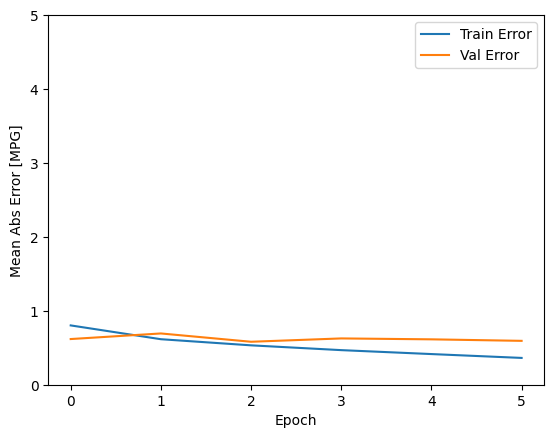

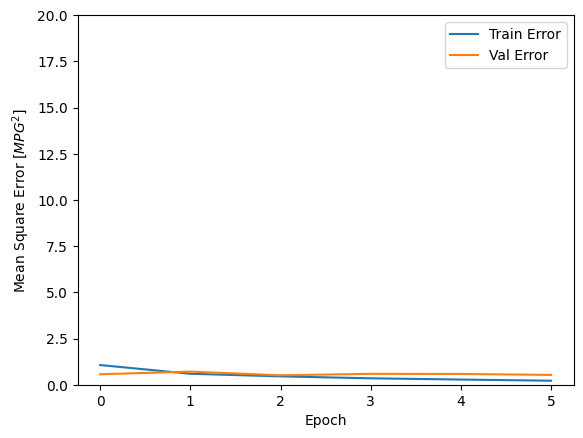

In [ ]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

Evaluación:

In [ ]:
#X_test = np.array(X_test)
#https://www.tensorflow.org/tutorials/keras/regression?hl=es-419
loss, mae, mse = model.evaluate(encoded_test, y_test, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MAE".format(mae))

17/17 - 0s - loss: 0.6055 - mae: 0.6207 - mse: 0.6055 - 405ms/epoch - 24ms/step
Testing set Mean Abs Error:  0.62 MPG
